# DL Challenge

Team:
German Novykov
Alexiy Pidnebesnyi
Mark Vaykul

## Introduction

This document provides an overview of the Deep Learning model developed to recognize different species of cats, including tigers, lions, cheetahs, and more. The model leverages advanced neural network architectures to accurately classify images of various cat species. This guide covers the model's design, implementation details, and usage instructions, serving as a comprehensive resource for users and developers alike.

Our project comprises three distinct models:
1. **From Scratch**: Our first model is trained from scratch using TensorFlow, allowing us to tailor the architecture to our specific needs.
2. **Fine-Tuning Pre-Trained Model**: The second model involves fine-tuning a pre-trained ResNet model, adapting it to the task of cat species recognition while utilizing existing learned features.
3. **Google ViT**: The third and strongest model employs Google's Vision Transformer (ViT) provided by HuggingFace. This model is not only the most robust

## Installing and Importing necessary libraies  

To begin building our deep learning model, we first import the necessary libraries and modules from TensorFlow and related packages. This includes everything from layers for constructing the model to utilities for handling our image data:


In [ ]:
!pip install tensorflow scikit-learn seaborn matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Preparing the Data
We organize our data into training, validation, and test datasets. This step is crucial for training our model effectively, ensuring it can generalize well to new, unseen data. We specify batch size, image dimensions, and the split ratio for validation data:

Images automatically are given classes based on folder names, ['Cat', 'Cheetah', 'Leopard', 'Lion', 'Tiger']

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set the parameters for your data
batch_size = 32
image_size = (160,160)
validation_split = 0.2


### Creating the Training Dataset
We use the image_dataset_from_directory method to load and preprocess images directly from the directory structured dataset. Here, we create the training dataset:

In [ ]:

train_ds = image_dataset_from_directory(
    directory='./train/train',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='training',
    seed=123
)

## Creating the Validation Dataset
Similarly, we set up the validation dataset to evaluate the model during training:

In [ ]:
validation_ds = image_dataset_from_directory(
    directory='./train/train',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

### Creating the Test Dataset
Lastly, the test dataset is prepared, which will be used to evaluate the model's performance after training:

In [ ]:
test_ds = image_dataset_from_directory(
    directory='./test',
    batch_size=batch_size,
    image_size=image_size
)

### Verifying Dataset Setup
After setting up the datasets, we can inspect the classes and some batch data to ensure everything is loaded correctly:

In [2]:
class_names = train_ds.class_names
print(class_names)
print(train_ds)
for images, labels in train_ds.take(1):  # 'take(1)' takes just one batch from the dataset
    print("Shape of training images:", images.shape)  # Prints the shape of images
    print("Shape of training labels:", labels.shape)

Found 2026 files belonging to 5 classes.
Using 1621 files for training.
Found 2026 files belonging to 5 classes.
Using 405 files for validation.
Found 473 files belonging to 1 classes.
['Cat', 'Cheetah', 'Leopard', 'Lion', 'Tiger']
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Shape of training images: (32, 160, 160, 3)
Shape of training labels: (32,)


## EDA and Data Augmentation

### Visualizing the Data

Before proceeding with model training, it's important to understand the nature of the data we're dealing with. Visualizing some samples from our training dataset provides insights into image quality, variations, and labeling:



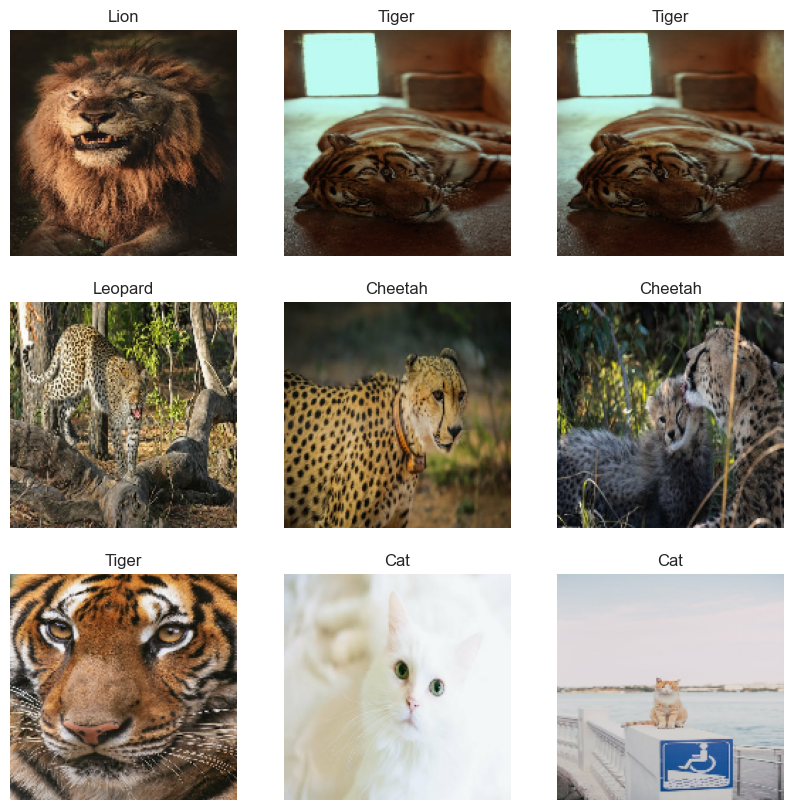

In [3]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Image Preprocessing and Edge Detection

### Importing Libraries and Reading an Image

We start by importing the required `cv2` library and loading an image which will be used to demonstrate various preprocessing techniques:

In [ ]:
import cv2
img_orig = cv2.imread('./train/train/Cat/Cat_Cat91.jpg')

### Edge Detection with Canny
Set thresholds based on the median pixel value to adapt to different lighting and apply blurring to reduce noise before edge detection:

In [ ]:
# set the lower and upper threshold
med_val = np.median(img_orig)
lower = int(max(0, .7 * med_val))
upper = int(min(255, 1.3 * med_val))

# blurring with ksize = 3
img_k3 = cv2.blur(img_orig, ksize = (3, 3))
# canny detection with different thresholds
edges_k3 = cv2.Canny(img_k3, threshold1 = lower, threshold2 = upper)
edges_k3_2 = cv2.Canny(img_k3, lower, upper + 75)

# blurring with ksize = 5 
img_k5 = cv2.blur(img_orig, ksize = (5, 5))
# canny detection with different thresholds
edges_k5 = cv2.Canny(img_k5, lower, upper)
edges_k5_2 = cv2.Canny(img_k5, lower, upper + 75)

### Visualization
Visualize the results to compare effects of different kernels

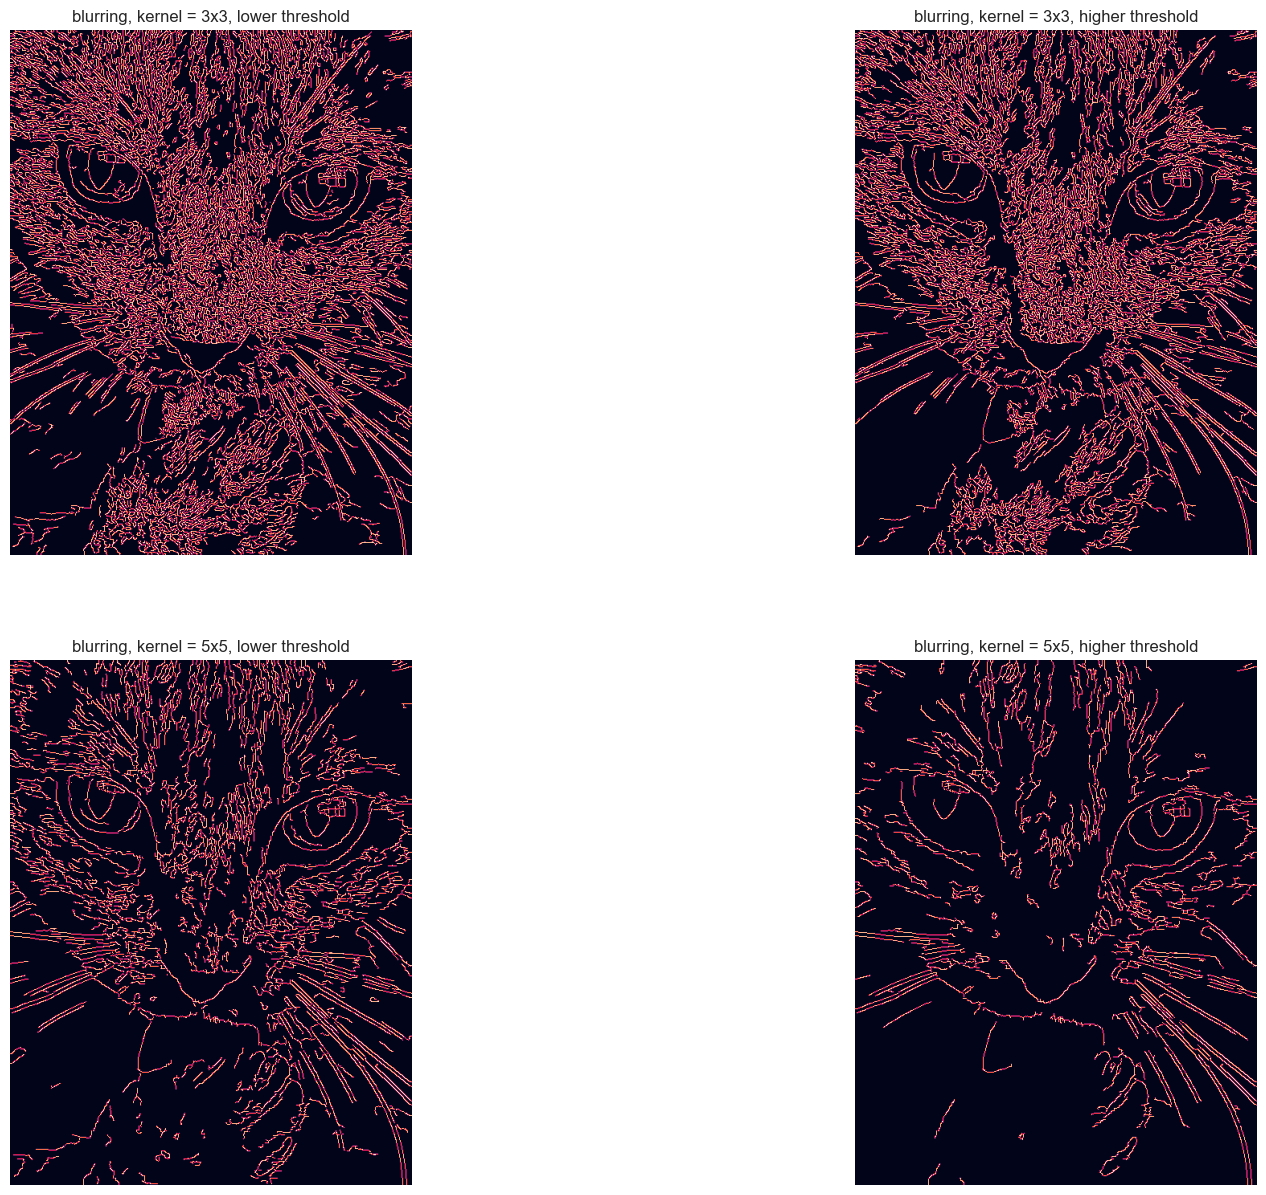

In [4]:
# plot the images
images = [edges_k3, edges_k3_2, edges_k5, edges_k5_2]
titles = ['blurring, kernel = 3x3, lower threshold', 
          'blurring, kernel = 3x3, higher threshold', 
          'blurring, kernel = 5x5, lower threshold', 
          'blurring, kernel = 5x5, higher threshold']
plt.figure(figsize = (20, 15))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(titles[i])
        
plt.show()




## Implementing Data Augmentation
For TensorFlow, data augmentation can be implemented using the tf.keras.preprocessing or tf.keras.layers.experimental.preprocessing modules, allowing you to define a series of random transformations that are applied on-the-fly during training.

In [5]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


## First Sequential Model

### Overview
This section outlines the architecture of our initial Sequential model, designed from scratch without prior pre-training. The model incorporates layers for data augmentation, pixel rescaling, convolution, pooling, and classification.

### Model Architecture
The model is structured to process images through sequential layers, starting with data augmentation, followed by pixel normalization, multiple convolutional and pooling layers, and finally, dense layers for classification:

In [6]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),  # Normalize pixel values from 0-255 to 0-1
  tf.keras.layers.Conv2D(32, 3, activation='relu'),  # First convolutional layer
  tf.keras.layers.MaxPooling2D(),  # First pooling layer
  tf.keras.layers.Conv2D(32, 3, activation='relu'),  # Second convolutional layer
  tf.keras.layers.MaxPooling2D(),  # Second pooling layer
  tf.keras.layers.Conv2D(32, 3, activation='relu'),  # Third convolutional layer
  tf.keras.layers.MaxPooling2D(),  # Third pooling layer
  tf.keras.layers.Flatten(),  # Flatten the output to a 1D array for the dense layer
  tf.keras.layers.Dense(160, activation='relu'),  # Dense layer with 160 neurons
  tf.keras.layers.Dense(5)  # Output layer with 5 classes
])


### Model Compilation
The model is compiled with the Adam optimizer, using sparse categorical crossentropy as the loss function, and accuracy as the metric for evaluation. This setup is chosen for its effectiveness in multi-class classification tasks:


Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.2536 - loss: 1.5828 - val_accuracy: 0.3407 - val_loss: 1.5394
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4330 - loss: 1.3658 - val_accuracy: 0.3432 - val_loss: 1.8090
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4475 - loss: 1.2694 - val_accuracy: 0.4716 - val_loss: 1.5053
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5217 - loss: 1.1792 - val_accuracy: 0.5407 - val_loss: 1.2362
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5575 - loss: 1.0946 - val_accuracy: 0.4469 - val_loss: 1.4570


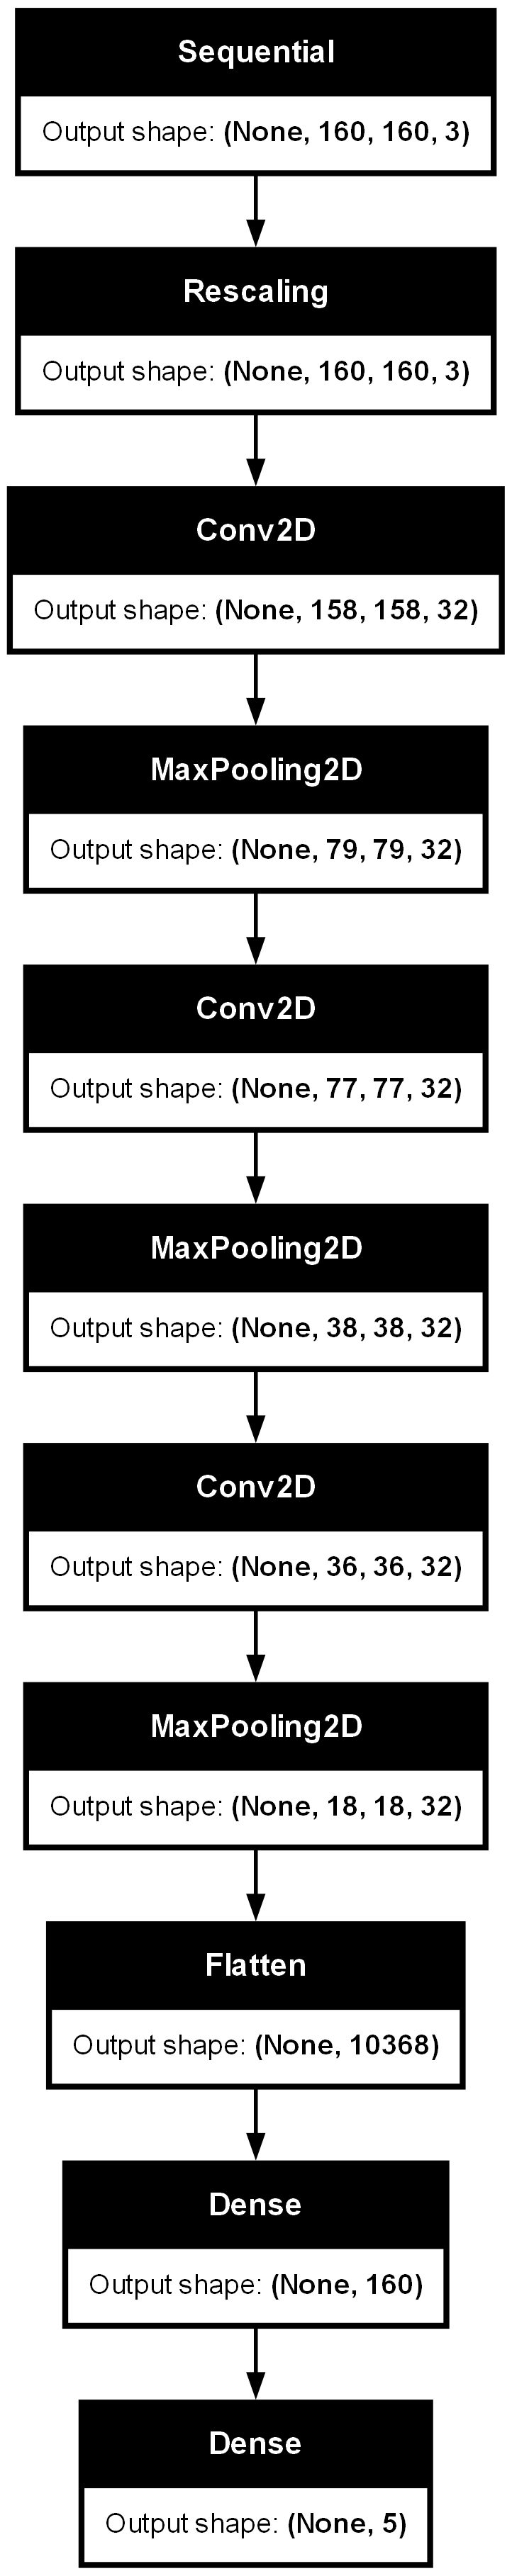

In [7]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

history = model.fit(
  train_ds,
  validation_data=validation_ds,
            epochs = 5
)
tf.keras.utils.plot_model(model, show_shapes=True)


## Evaluating Model Performance

### Visualizing Training Results
To better understand the model's performance over time, we implement a function called `plotLosses` to visualize the loss and accuracy curves during training. This function creates two plots: one for loss and the other for accuracy, for both the training and validation datasets. This visual feedback is essential for tuning the model and diagnosing issues with model training.


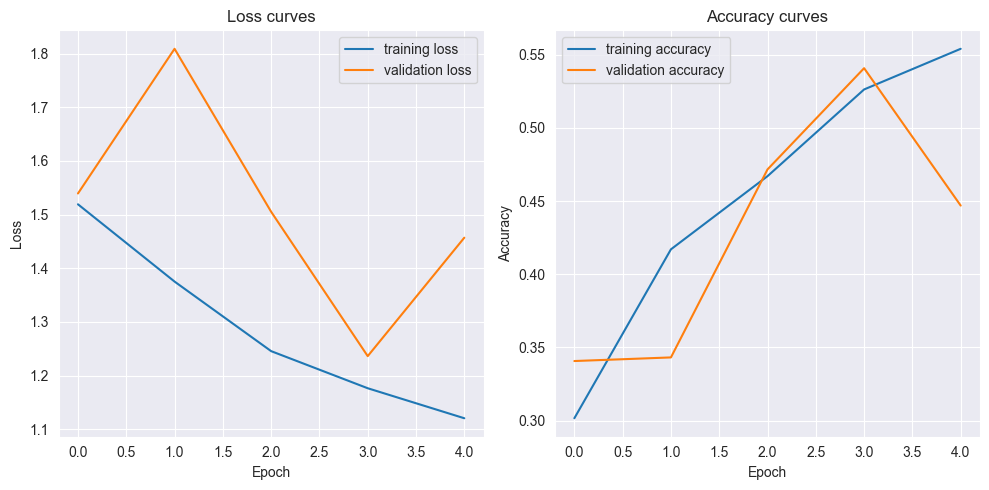

In [8]:
def plotLosses(history):
  # Create a figure and a grid of subplots with a single call
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
  # Plot the loss curves on the first subplot
  ax1.plot(history.history['loss'], label='training loss')
  ax1.plot(history.history['val_loss'], label='validation loss')
  ax1.set_title('Loss curves')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  # Plot the accuracy curves on the second subplot
  ax2.plot(history.history['accuracy'], label='training accuracy')
  ax2.plot(history.history['val_accuracy'], label='validation accuracy')
  ax2.set_title('Accuracy curves')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  # Adjust the spacing between subplots
  fig.tight_layout()
  # Show the figure
  plt.show()


plotLosses(history)

### Confusion Matrix Function
To quantitatively assess the model's classification performance across different classes, we use a confusion matrix. This matrix helps identify which classes are being correctly classified, and which are commonly confused with others. We define a function `confusionMatrix` to compute and plot this matrix using the model's predictions on the validation dataset.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


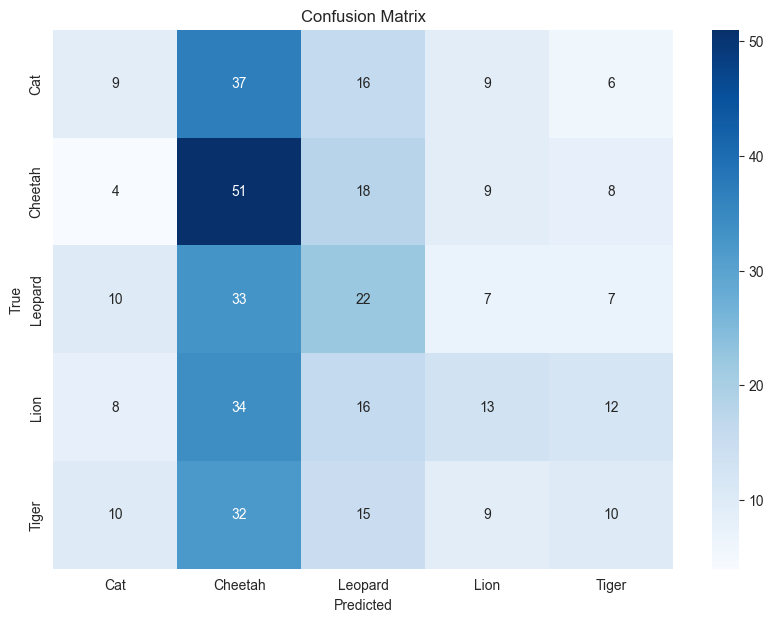

In [9]:

def confusionMatrix(model, validation_ds, class_names):
    # Assume your model and test_ds are already defined and loaded correctly as per your code.
    predictions = model.predict(validation_ds)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Extract true labels from the test dataset
    true_labels = []
    for images, labels in validation_ds:
        true_labels.extend(labels.numpy())
    
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_classes)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
confusionMatrix(model, validation_ds, class_names)

### Preparing Submission Data
The predictions are paired with their corresponding image IDs to prepare a submission dataframe. This dataframe is structured to match the expected format for submission, with columns for id and label

In [10]:
import pandas as pd
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)


file_paths = test_ds.file_paths
ids = [fp.split('\\')[-1].split('.')[0] for fp in file_paths]

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_classes
})

submission_df.to_csv('submission.csv', index=False)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


## Conclusion
This step completes the process of training, validating, and testing the model. The resulting submission.csv file is ready for submission to assess the model's ability to generalize to new data.

## 2nd Model: MobileNet V2 Using Transfer Learning

The second model leverages the power of transfer learning using the pre-trained MobileNet V2 architecture developed by Google. This model, originally trained on the vast ImageNet dataset, serves as a robust feature extractor for our specific task of cat species recognition.

### Setting Up the Pre-Trained Model
We begin by initializing the MobileNet V2 model as a base for feature extraction, setting up the necessary preprocessing, and configuring the model to not train the pre-existing weights:

In [11]:

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False


### Feature Extraction
The MobileNet V2 base converts each input image into a comprehensive block of features. Here's how we process an example batch of images to extract features:

In [12]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print("Feature batch shape:", feature_batch.shape)

(32, 5, 5, 1280)


### Building the Classifier
To derive predictions from these features, we utilize global average pooling to reduce the feature dimensions and then apply a dense layer for classification:

In [13]:
# Add a global spatial average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
base_model.trainable = False

# Build the final model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # Apply data augmentation
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Add a dropout layer for regularization
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

(32, 1280)


### Model Compilation and Initial Evaluation
Compile the model and evaluate it on the validation dataset to establish a baseline before further training:

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

              
loss0, accuracy0 = model.evaluate(validation_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

### Training the Model
Proceed to train the model for a defined number of epochs, using the training and validation datasets:

In [21]:
initial_epochs = 10
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)
plotLosses(history)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.2658 - loss: 1.7514 - val_accuracy: 0.5136 - val_loss: 1.2861
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.4828 - loss: 1.3447 - val_accuracy: 0.6765 - val_loss: 0.9873
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6035 - loss: 1.0981 - val_accuracy: 0.7580 - val_loss: 0.8054
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.6745 - loss: 0.9066 - val_accuracy: 0.7778 - val_loss: 0.6911
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.7385 - loss: 0.7810 - val_accuracy: 0.8148 - val_loss: 0.6147
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.7711 - loss: 0.6775 - val_accuracy: 0.8272 - val_loss: 0.5542
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.7878 - loss: 0.6250 - val_accuracy: 0.8444 - val_loss: 0.5225
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8061 - loss: 0.5689 - val_accuracy: 0.8593 - v

## Fine-Tuning the MobileNet V2 Model

### Enabling Fine-Tuning on the Base Model
Fine-tuning involves unfreezing the layers of the pre-trained model to allow subtle adjustments to the weights. This can help in boosting the final accuracy by adapting the more abstract representations learned by the model to the new task.


In [23]:
# Make the base model trainable
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Recompile the Model
Recompile the model with a lower learning rate to ensure that the model only makes minor adjustments, avoiding overfitting:

In [25]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


### Continue Training
Continue training the model with additional epochs to allow the fine-tuned layers to adjust:

Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.6586 - loss: 0.8966 - val_accuracy: 0.8716 - val_loss: 0.3856
Epoch 12/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.7687 - loss: 0.6688 - val_accuracy: 0.8840 - val_loss: 0.3570
Epoch 13/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.7875 - loss: 0.5609 - val_accuracy: 0.8840 - val_loss: 0.3532
Epoch 14/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8282 - loss: 0.4793 - val_accuracy: 0.8840 - val_loss: 0.3157
Epoch 15/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.8449 - loss: 0.4464 - val_accuracy: 0.8914 - val_loss: 0.3057
Epoch 16/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.8785 - loss: 0.3861 - val_accuracy: 0.8938 - val_loss: 0.2927
Epoch 17/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.8847 - loss: 0.3447 - val_accuracy: 0.8938 - val_loss: 0.2821
Epoch 18/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.8970 - loss: 0.2989 - val_acc

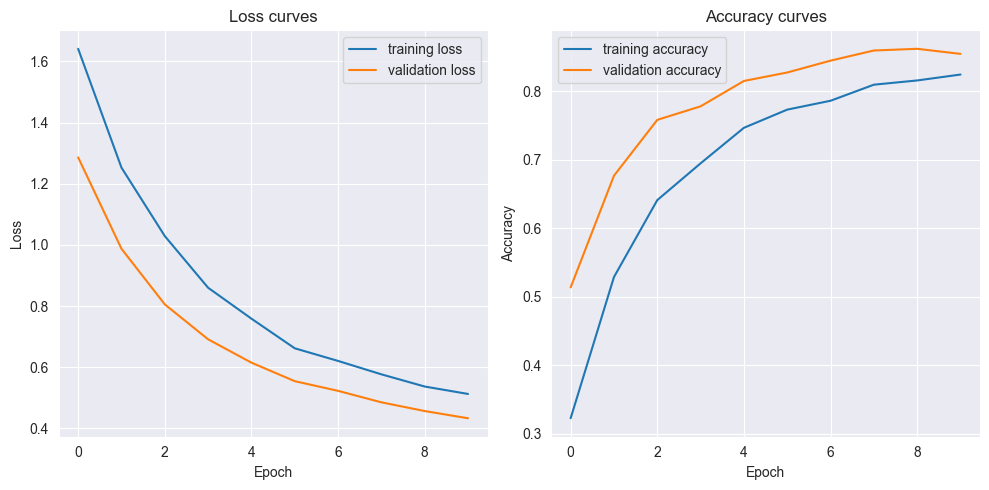

In [26]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_ds)
plotLosses(history_fine)  # Plotting the new training history


### Model Evaluation
Evaluate the model's improved performance using the confusion matrix and visualize the accuracy

13/13 ━━━━━━━━━━━━━━━━━━━━ 7204s 600s/step


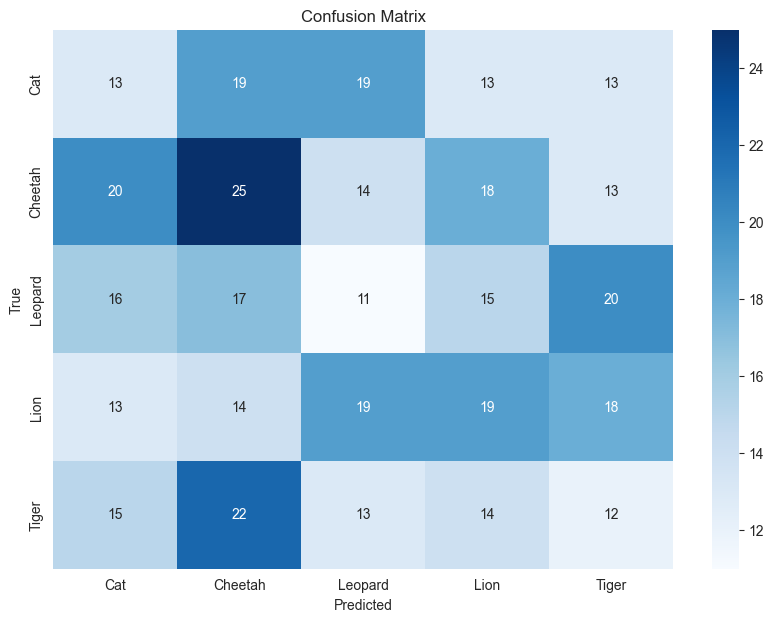

In [27]:
confusionMatrix(model, validation_ds, class_names)


### Visualizing Predictions
Display a batch of images with their predicted labels to visually confirm the model's performance

Predictions:
 [1 0 4 1 2 0 1 1 4 1 1 4 3 1 4 2 4 0 4 1 3 3 1 2 4 1 1 0 0 2 2 4]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


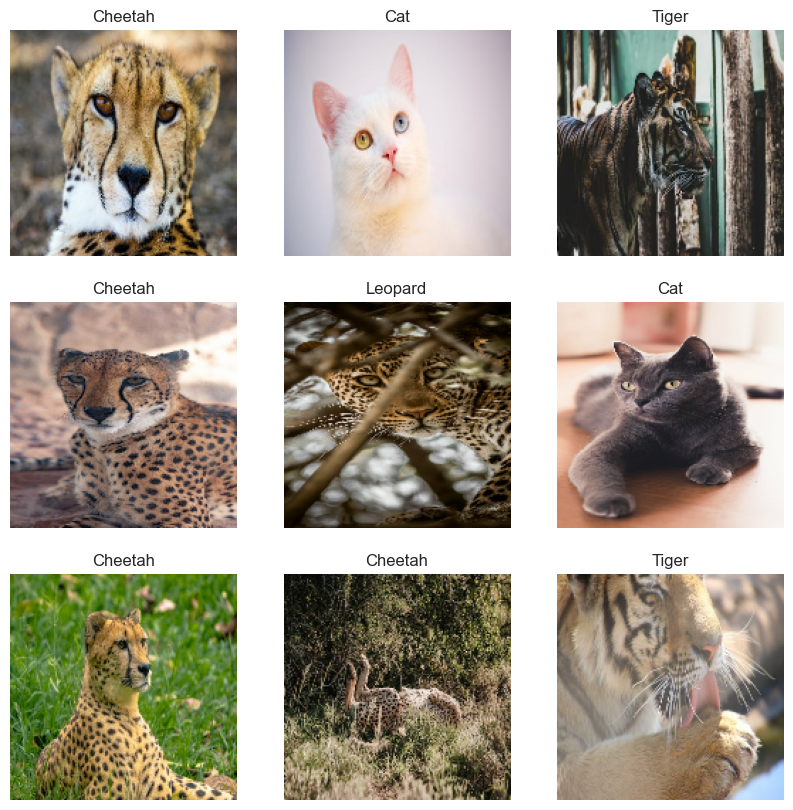

In [28]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Prepare Submission
Finally, use the model to predict on the entire test dataset and prepare a submission file:

In [29]:
# Predict classes on the entire test dataset
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Extract image IDs and prepare the submission dataframe
file_paths = test_ds.file_paths
ids = [fp.split('\\')[-1].split('.')[0] for fp in file_paths]

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_classes
})
submission_df.to_csv('submission_mobilenet.csv', index=False)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step


### Conclusion
Through fine-tuning and careful re-training, this approach significantly improves the model's ability to adapt to the specific characteristics of the new dataset, enhancing its overall performance and readiness for operational use.

# 3rd Google ViT Model using Transfer Learning (google/vit-base-patch16-224)

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224.
